**Bank Marketing Campaign Analysis Project**


[Visit streamlit](https://vaishnavikokkirala-project-app-wamdno.streamlit.app/)

[visit pythoncode](https://drive.google.com/file/d/1TCV4QWnTcmPz6xgC0-p43CjnHhGxCzCx/view?usp=drive_link)

[Visit dagshub](https://dagshub.com/kokkirala.vaishnavi15/Major-Project/experiments)

[Visit docker](https://hub.docker.com/repositories/vaishnavikokkirala)

[Visit resume](https://drive.google.com/file/d/1OuzTKGr5DCaoY2TWyhYEO21qLfilMHtn/view)

[Visit presentation](https://drive.google.com/file/d/1ZHOD_qAWEpFseE5-q1Ewo3jsyS_AKlAx/view)

[visit github](https://github.com/vaishnavikokkirala/project)

[visit pythonproject](https://drive.google.com/drive/folders/1vRtM42QBD2jYN0uv166uzzxupsh0jQrp?usp=drive_link)

[visit ML-project plan](https://docs.google.com/document/d/1gMu8DQ8v-6p5WnsYg3QDHOTZLeK7v9Vi/)

In [1]:
!pip install --upgrade xgboost

In [2]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.5.2
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License
        
        Copyright (c) 2007-2024 The scikit-learn developers.
        All rights reserved.
        
        Redistribution and use in source and binary forms, with or without
        modification, are permitted provided that the following conditions are met:
        
        * Redistributions of source code must retain the above copyright notice, this
          list of conditions and the following disclaimer.
        
        * Redistributions in binary form must reproduce the above copyright notice,
          this list of conditions and the following disclaimer in the documentation
          and/or other materials provided with the distribution.
        
        * Neither the name of the copyright holder nor the names of its
          contributors may be used to endorse or promote produ

In [3]:
# prompt: upgrade scikit-learn to version 1.5

!pip install scikit-learn==1.5.2


In [5]:
!pip install -q dagshub mlflow

In [6]:
# prompt: from ydata_profiling import ProfileReport this package is not found

!pip install ydata-profiling


  Using cached dacite-1.8.1-py3-none-any.whl.metadata (15 kB)
Using cached dacite-1.8.1-py3-none-any.whl (14 kB)
  Attempting uninstall: dacite
    Found existing installation: dacite 1.6.0
    Uninstalling dacite-1.6.0:
      Successfully uninstalled dacite-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dagshub 0.4.0 requires dacite~=1.6.0, but you have dacite 1.8.1 which is incompatible.


In [7]:
# prompt: install package mlflow

!pip install mlflow


In [8]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix,classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

In [9]:
#step 1: setup the database
# Create a normalized database (3NF)

data_full = pd.read_csv('/content/bank-full.csv', sep=',')
data_small = pd.read_csv('/content/bank.csv', sep=',')

conn = sqlite3.connect('bank_marketing.db')
cursor = conn.cursor()

cursor.execute('''CREATE TABLE IF NOT EXISTS clients (
    client_id INTEGER PRIMARY KEY AUTOINCREMENT,
    age INTEGER,
    job TEXT,
    marital_status TEXT,  -- Changed 'marital' to 'marital_status'
    education TEXT,
    loan_status TEXT,     -- Changed 'default' to 'loan_status'
    balance INTEGER,
    housing TEXT,
    loan TEXT
)''')

cursor.execute('''CREATE TABLE IF NOT EXISTS campaigns (
    campaign_id INTEGER PRIMARY KEY AUTOINCREMENT,
    client_id INTEGER,
    contact TEXT,
    day INTEGER,
    month TEXT,
    duration INTEGER,
    campaign INTEGER,
    pdays INTEGER,
    previous INTEGER,
    poutcome TEXT,
    y TEXT,
    FOREIGN KEY(client_id) REFERENCES clients(client_id)
)''')

def normalize_and_insert_data(df):
    for _, row in df.iterrows():
        cursor.execute('''INSERT INTO clients (age, job, marital_status, education, loan_status, balance, housing, loan)
                          VALUES (?, ?, ?, ?, ?, ?, ?, ?)''',
                       (row['age'], row['job'], row['marital'], row['education'],
                        row['default'], row['balance'], row['housing'], row['loan']))
        client_id = cursor.lastrowid
        cursor.execute('''INSERT INTO campaigns (client_id, contact, day, month, duration, campaign, pdays, previous, poutcome, y)
                          VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)''',
                       (client_id, row['contact'], row['day'], row['month'], row['duration'],
                        row['campaign'], row['pdays'], row['previous'], row['poutcome'], row['y']))

normalize_and_insert_data(data_full)
conn.commit()

In [10]:
# step:2
# Write SQL join statement to fetch data from the database and into Pandas DataFrame.

query = '''
SELECT c.*, cp.contact, cp.day, cp.month, cp.duration, cp.campaign, cp.pdays, cp.previous, cp.poutcome, cp.y
FROM clients c
JOIN campaigns cp ON c.client_id = cp.client_id
'''
data_from_db = pd.read_sql_query(query, conn)
print(data_from_db)

       client_id  age           job marital_status  education loan_status  \
0              1   58    management        married   tertiary          no   
1              2   44    technician         single  secondary          no   
2              3   33  entrepreneur        married  secondary          no   
3              4   47   blue-collar        married    unknown          no   
4              5   33       unknown         single    unknown          no   
...          ...  ...           ...            ...        ...         ...   
45206      45207   51    technician        married   tertiary          no   
45207      45208   71       retired       divorced    primary          no   
45208      45209   72       retired        married  secondary          no   
45209      45210   57   blue-collar        married  secondary          no   
45210      45211   37  entrepreneur        married  secondary          no   

       balance housing loan    contact  day month  duration  campaign  pday

In [11]:
data_from_db

,client_id,age,job,marital_status,education,loan_status,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,2,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,3,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,4,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,5,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,45207,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,45208,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,45209,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,45210,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [12]:
# step: 3
# Explore the data to determine if you need to stratify it by some attribute when
# doing train/test split. Perform the train/test split./

X = data_from_db.drop('y', axis=1)
y = data_from_db['y'].apply(lambda x: 1 if x == 'yes' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
print(data_from_db.columns)

Index(['client_id', 'age', 'job', 'marital_status', 'education', 'loan_status',
       'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration',
       'campaign', 'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

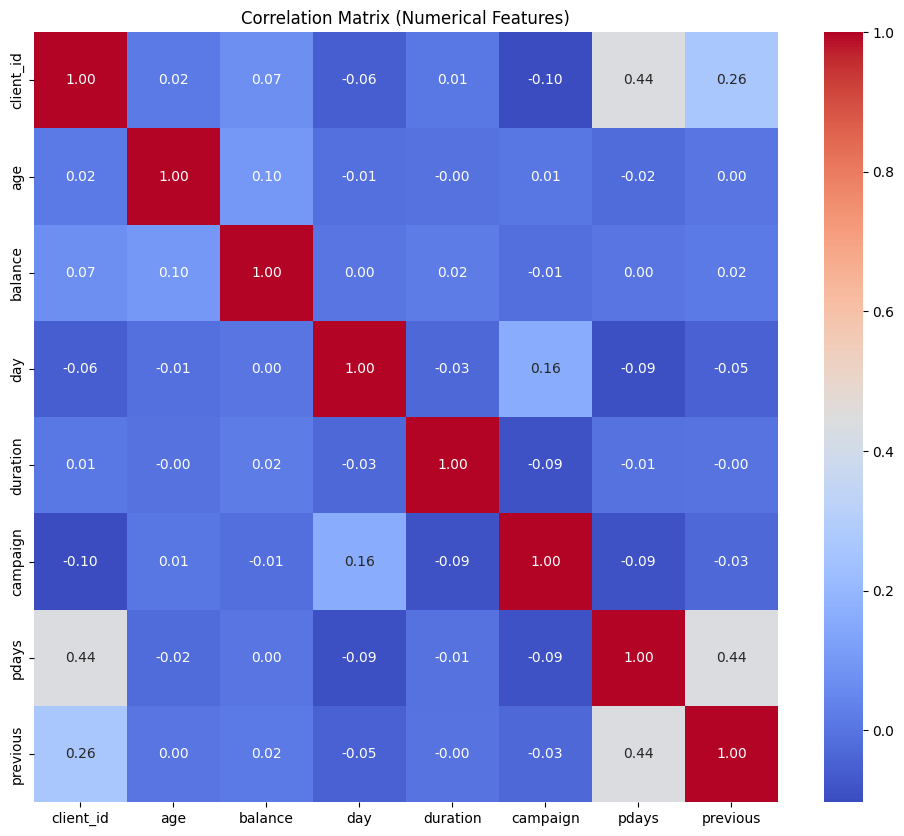

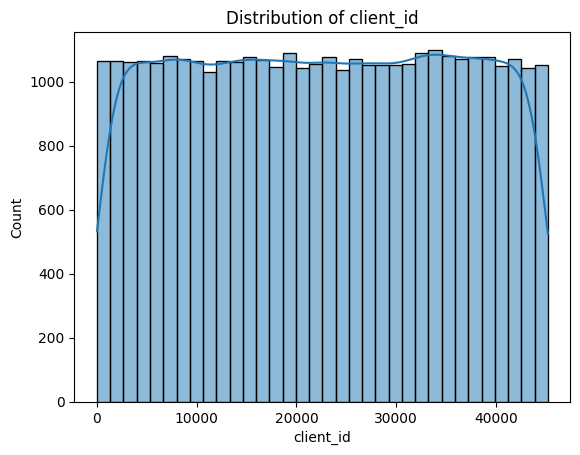

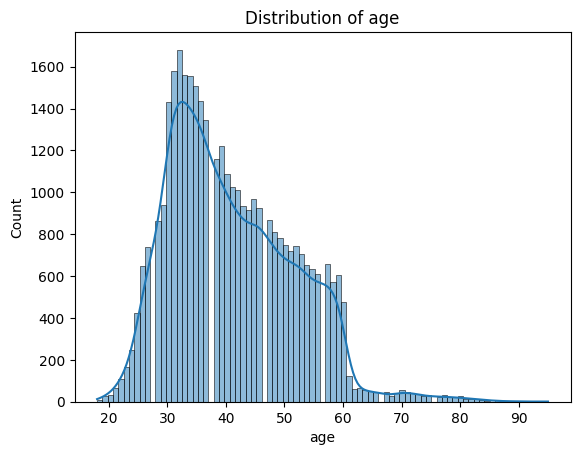

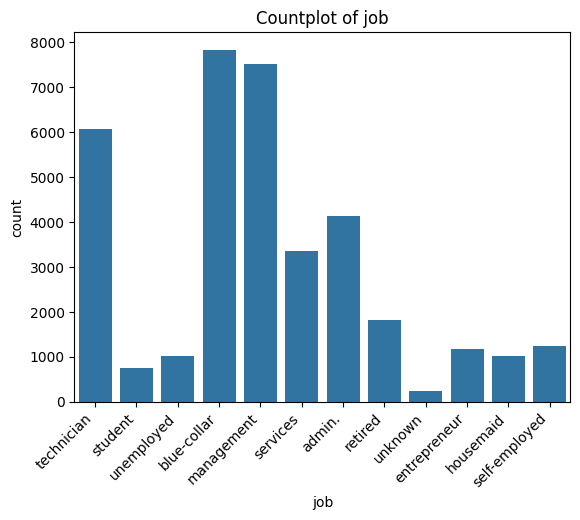

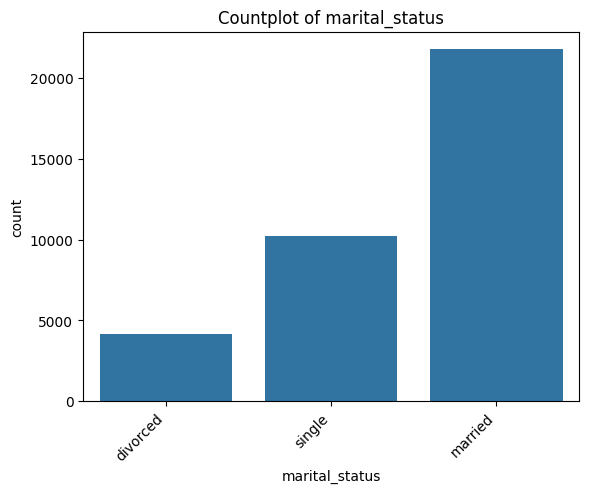

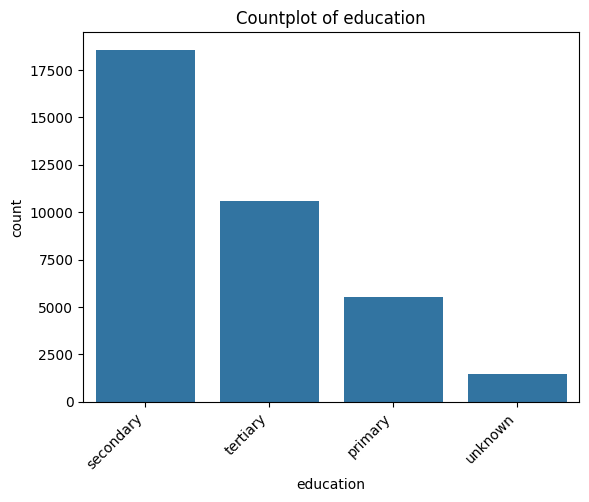

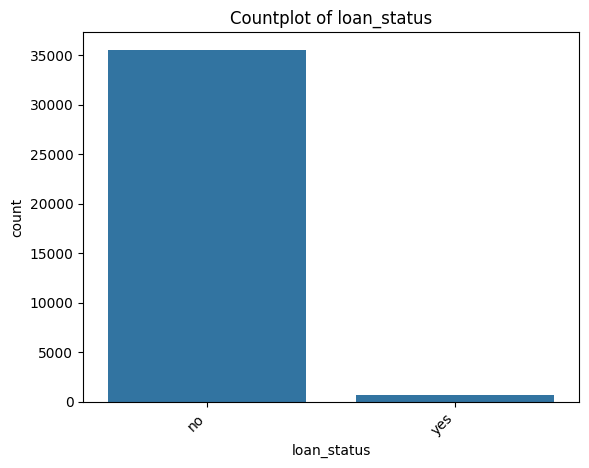

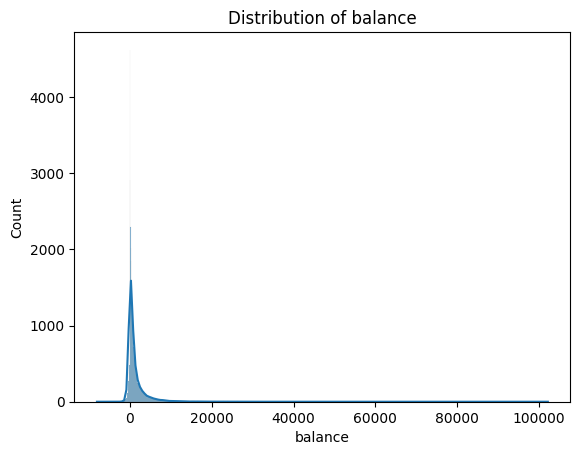

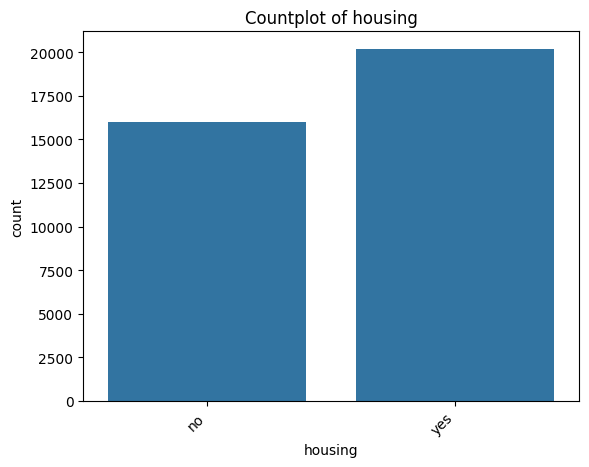

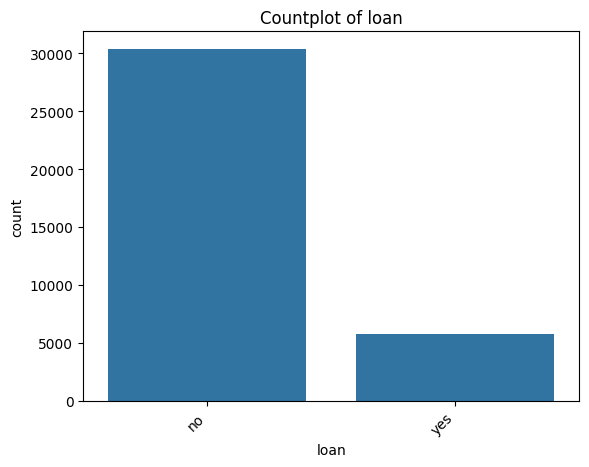

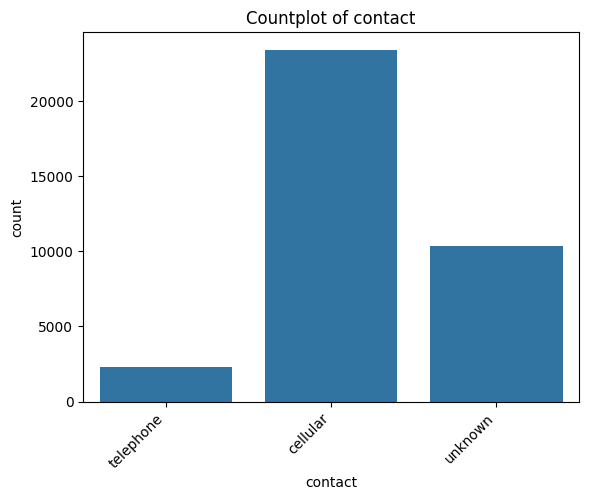

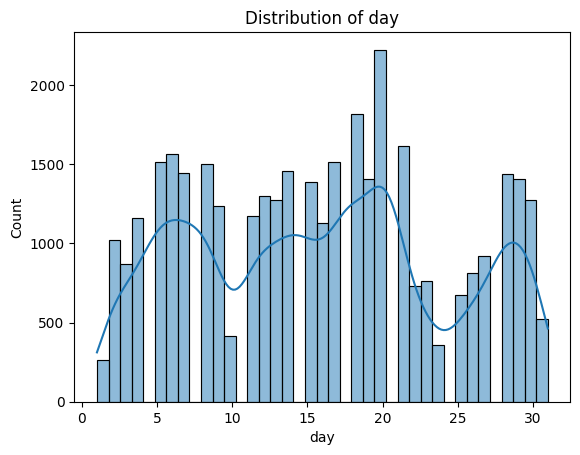

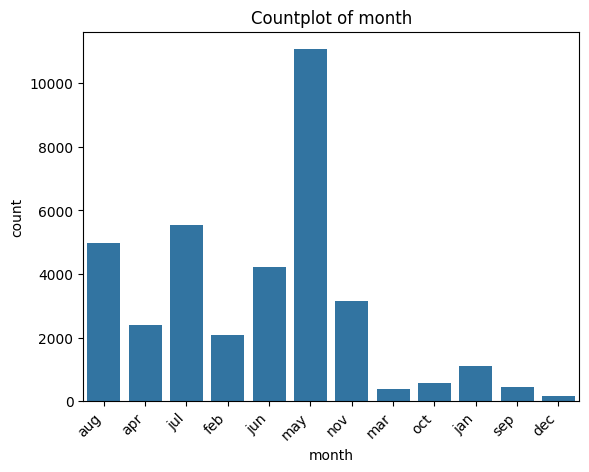

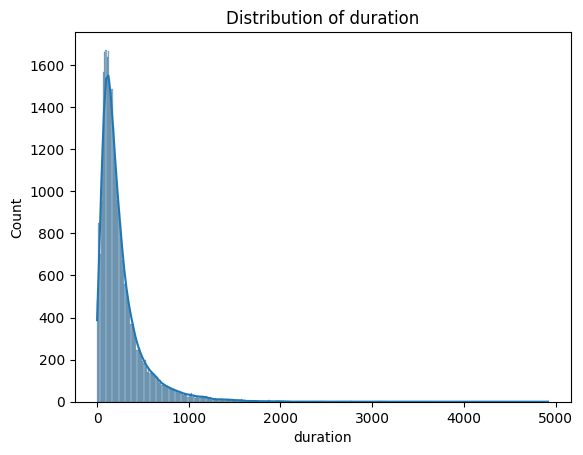

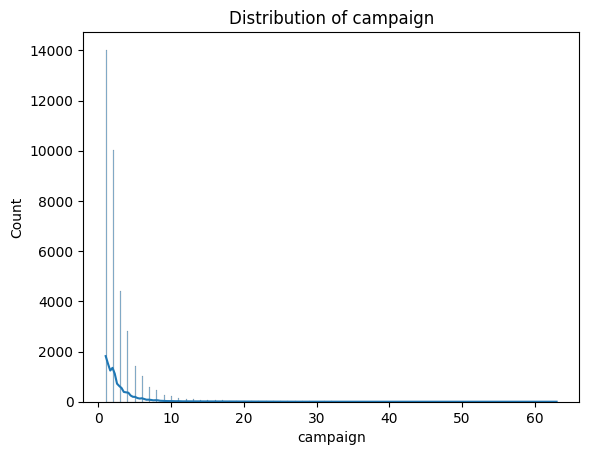

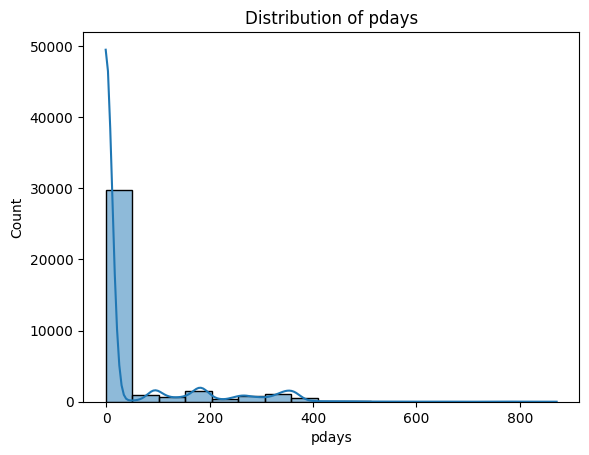

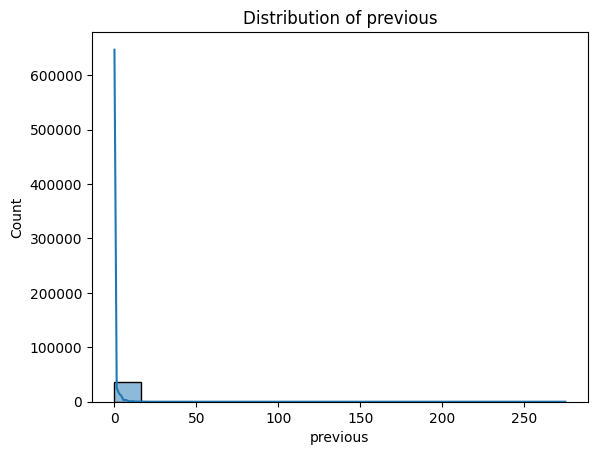

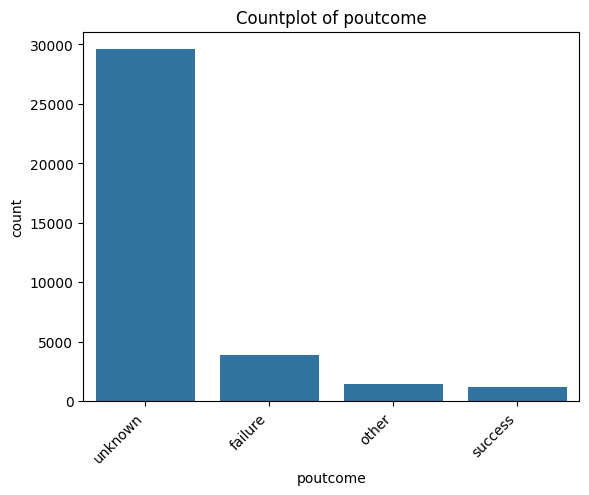

Cleanup Tasks:
- Cap outliers in age
- Cap outliers in balance
- Cap outliers in duration
- Cap outliers in campaign
- Cap outliers in pdays
- Cap outliers in previous
- Handle imbalanced data
- Create binary feature for 'pdays' (-1 vs. not -1)
- Apply log transformation to 'duration'
- Encode categorical variables: ['job', 'marital_status', 'education', 'loan_status', 'housing', 'loan', 'contact', 'month', 'poutcome']
['Cap outliers in age', 'Cap outliers in balance', 'Cap outliers in duration', 'Cap outliers in campaign', 'Cap outliers in pdays', 'Cap outliers in previous', 'Handle imbalanced data', "Create binary feature for 'pdays' (-1 vs. not -1)", "Apply log transformation to 'duration'", "Encode categorical variables: ['job', 'marital_status', 'education', 'loan_status', 'housing', 'loan', 'contact', 'month', 'poutcome']"]


In [13]:
# step: 4
# Explore the data using yprofile and correlation matrix. Make observations about features,
# distributions, capped values, and missing values.Create a list of data cleanup tasks.

# ydata-profiling
profile = ProfileReport(pd.concat([X_train, y_train.rename('y')], axis=1), title="Profiling Report")
profile.to_file("bank_marketing_profile.html")  # Save the report

# Correlation Matrix (Numerical Features Only)
X_train_numeric = X_train.select_dtypes(include=np.number)
plt.figure(figsize=(12, 10))
sns.heatmap(X_train_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Numerical Features)')
plt.show()

def explore_features(df):
    for col in df.columns:
        plt.figure()
        if pd.api.types.is_numeric_dtype(df[col]):
            sns.histplot(df[col], kde=True)
            plt.title(f'Distribution of {col}')
            plt.show()
        else:
            sns.countplot(data=df, x=col)
            plt.title(f'Countplot of {col}')
            plt.xticks(rotation=45, ha='right')
            plt.show()

explore_features(X_train)

cleanup_tasks = []

#missing values
if X_train.isnull().sum().sum() > 0:
    cleanup_tasks.append("Handle missing values")

#outliers
for col in X_train_numeric.columns:
    Q1 = X_train_numeric[col].quantile(0.25)
    Q3 = X_train_numeric[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = X_train_numeric[(X_train_numeric[col] < (Q1 - 1.5 * IQR)) | (X_train_numeric[col] > (Q3 + 1.5 * IQR))]
    if not outliers.empty:
        cleanup_tasks.append(f"Cap outliers in {col}")

#highly correlated features
corr_matrix = X_train_numeric.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
if to_drop:
    cleanup_tasks.append(f"Handle highly correlated features: {to_drop}")

#imbalanced data
if y_train.value_counts()[0]/len(y_train) < 0.2 or y_train.value_counts()[0]/len(y_train) > 0.8:
    cleanup_tasks.append("Handle imbalanced data")

# Example: If 'pdays' has many -1 values (meaning client was not contacted before), consider creating a binary feature
if (X_train['pdays'] == -1).sum() > 0:
    cleanup_tasks.append("Create binary feature for 'pdays' (-1 vs. not -1)")

# Example: If 'duration' is highly skewed, consider log transformation
if X_train_numeric['duration'].skew() > 1:
    cleanup_tasks.append("Apply log transformation to 'duration'")

#Categorical encoding
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
if categorical_cols:
    cleanup_tasks.append(f"Encode categorical variables: {categorical_cols}")

if cleanup_tasks:
    print("Cleanup Tasks:")
    for task in cleanup_tasks:
        print(f"- {task}")
else:
    print("No cleanup tasks identified based on this analysis.")

print(cleanup_tasks)

In [14]:
f1_scores = {}

In [15]:
# step: 5
# Experiment #1: Create a pipeline for preprocessing (StandardScaler, MinMaxScaler, LogTransformation, OneHotEncoding)
# and Logistic Regression. Log F1-score/(TP,TN,FN,FP)  in MLFlow on DagsHub. – Cross validation 3/10 folds.
# Results—mean/std of CV results and results on the whole training data – add in parameter hyper tuning/

import dagshub
dagshub.init(repo_owner='kokkirala.vaishnavi15', repo_name='Major-Project', mlflow=True)


# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('scaler', StandardScaler()),
        ('minmax', MinMaxScaler()),
        ('log_transform', FunctionTransformer(np.log1p, validate=True))
    ]), ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['job', 'marital_status', 'education', 'loan_status', 'housing', 'loan', 'contact', 'month', 'poutcome'])
])

# Define pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Hyperparameter tuning
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'lbfgs']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='f1', verbose=1, n_jobs=1)
grid_search.fit(X_train, y_train)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(exclude='object').columns.tolist()

# One-hot encode ALL categorical features for correlation calculation
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_encoded = pd.concat([X_train[numerical_cols], pd.DataFrame(encoder.fit_transform(X_train[categorical_cols]), index=X_train.index, columns=encoder.get_feature_names_out(categorical_cols))], axis=1)
X_test_encoded = pd.concat([X_test[numerical_cols], pd.DataFrame(encoder.transform(X_test[categorical_cols]), index=X_test.index, columns=encoder.get_feature_names_out(categorical_cols))], axis=1)


# Best model
best_pipeline = grid_search.best_estimator_
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

# Metrics
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred) #Added classification report

# Cross-validation results
cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=3, scoring='f1', n_jobs=1)
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

# Extract confusion matrix components
TN, FP, FN, TP = conf_matrix.ravel()

# MLflow tracking (Set your tracking URI)
mlflow.set_tracking_uri("https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow")
mlflow.set_experiment("Bank Marketing Experiment - 1")

with mlflow.start_run():
    mlflow.log_param("classifier", "LogisticRegression")
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("F1_Score_Train", f1_train)
    mlflow.log_metric("F1_Score_Test", f1_test)
    mlflow.log_metric("True_Positives", TP)
    mlflow.log_metric("True_Negatives", TN)
    mlflow.log_metric("False_Positives", FP)
    mlflow.log_metric("False_Negatives", FN)
    mlflow.log_metric("CV_Mean_F1_Score", mean_cv_score)
    mlflow.log_metric("CV_Std_F1_Score", std_cv_score)
    mlflow.sklearn.log_model(best_pipeline, "model")
    mlflow.log_text(class_report, "classification_report.txt")

print("Training F1 Score:", f1_train)
print("Test F1 Score:", f1_test)
print("Cross-validation Mean F1 Score:", mean_cv_score)
print("Cross-validation Std Dev F1 Score:", std_cv_score)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

f1_scores["Training F1 Score"] = f1_test
f1_scores["Test F1 Score"] = f1_test
f1_scores["Cross-validation Mean F1 Score"] = mean_cv_score
f1_scores["Cross-validation Std Dev F1 Score"] = std_cv_score


Accessing as kokkirala.vaishnavi15

Initialized MLflow to track repo "kokkirala.vaishnavi15/Major-Project"

Repository kokkirala.vaishnavi15/Major-Project initialized!

Fitting 10 folds for each of 12 candidates, totalling 120 fits


2024/12/22 02:37:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run selective-lark-599 at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/0/runs/d3123418b72a4e4f8851dfd456ba436d
🧪 View experiment at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/0
Training F1 Score: 0.4583525080533824
Test F1 Score: 0.4573170731707317
Cross-validation Mean F1 Score: 0.45751580301642386
Cross-validation Std Dev F1 Score: 0.018213965991141796
Confusion Matrix:
[[7778  207]
 [ 683  375]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7985
           1       0.64      0.35      0.46      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043



In [16]:
# step:6
# Experiment #2: Create a pipeline for preprocessing and use LogisticRegression, RidgeClassifier,
# RandomForestClassifier, and XGBClassifier. Log results in MLFlow on DagsHub.

classifiers = [
    ("LogisticRegression", LogisticRegression(max_iter=1000)),
    ("RidgeClassifier", RidgeClassifier()),
    ("RandomForestClassifier", RandomForestClassifier()),
    ("XGBClassifier", XGBClassifier())
]

for name, clf in classifiers:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score ({name}):", f1)
    f1_scores[f"{name}"]=f1
    mlflow.set_experiment(f"Bank Marketing Experiment - 2 ({name})")
    with mlflow.start_run():
        mlflow.log_param("classifier", name)
        mlflow.log_metric("F1_Score", f1)
        mlflow.sklearn.log_model(pipeline, "model")

F1 Score (LogisticRegression): 0.4331450094161959


2024/12/22 02:37:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run delightful-robin-178 at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/1/runs/b87db66e70c24ed58994a8a6ca81b587
🧪 View experiment at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/1
F1 Score (RidgeClassifier): 0.3925729442970822


2024/12/22 02:37:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run sneaky-panda-226 at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/2/runs/d3b6684adaa247f683e680ba82f35a5e
🧪 View experiment at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/2
F1 Score (RandomForestClassifier): 0.49853715623171446


2024/12/22 02:38:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run secretive-bat-907 at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/3/runs/30fd97aa72fa4beb9b0f5f86d170ee0e
🧪 View experiment at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/3
F1 Score (XGBClassifier): 0.5462412114656571


2024/12/22 02:38:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run unleashed-shrike-448 at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/4/runs/1035b021aae1445a9ceda69fae8d768c
🧪 View experiment at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/4


In [17]:
# step:7
# Experiment #3: Perform feature engineering and attribute combination. Log results in MLFlow.

X_train_exp3 = X_train.copy()
X_test_exp3 = X_test.copy()
X_train_exp3["age_group"] = pd.cut(X_train_exp3["age"], bins=[0, 30, 60, 100], labels=["young", "middle", "senior"])
X_test_exp3["age_group"] = pd.cut(X_test_exp3["age"], bins=[0, 30, 60, 100], labels=["young", "middle", "senior"])
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['balance', 'duration', 'campaign', 'pdays', 'previous']),
    ('cat', OneHotEncoder(), ['job', 'marital_status', 'education', 'loan_status', 'housing', 'loan', 'contact', 'month', 'poutcome', 'age_group'])
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# GridSearch for Hyperparameter Tuning (Optional but recommended)
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__solver': ['lbfgs', 'liblinear']
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_exp3, y_train)
pipeline = grid_search.best_estimator_  # Update pipeline with best parameters

y_pred = pipeline.predict(X_test_exp3)

f1 = f1_score(y_test, y_pred)
f1_scores["Feature Engineering"]=f1
print("F1 Score (Feature Engineering):", f1)
mlflow.set_experiment(f"Bank Marketing Experiment - 3 (Feature Engineering)")
with mlflow.start_run():
    mlflow.log_param("experiment", "Feature Engineering")
    mlflow.log_metric("F1 Score", f1)
    mlflow.sklearn.log_model(pipeline, "model")

F1 Score (Feature Engineering): 0.4560975609756098


2024/12/22 02:39:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run gentle-horse-92 at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/6/runs/dedbcf5dacd840dcaa268c993a819783
🧪 View experiment at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/6


In [18]:
# step:8
# Experiment #4: Perform feature selection using Correlation Threshold, Feature Importance,
# and Variance Threshold. Log results in MLFlow.

from sklearn.feature_selection import VarianceThreshold, f_classif
from sklearn.model_selection import train_test_split


# Feature Selection with Correlation Threshold
correlation_threshold = 0.8
correlation_matrix = X_train_encoded.corr()
high_correlation_features = [
    column for column in correlation_matrix.columns
    if any(abs(correlation_matrix[column]) > correlation_threshold) and column not in numerical_cols #keep numerical columns
]
X_train_corr = X_train_encoded.drop(columns=high_correlation_features, errors='ignore')
X_test_corr = X_test_encoded.drop(columns=high_correlation_features, errors='ignore')

# Feature Selection with Feature Importance (RandomForest)
forest = RandomForestClassifier(random_state=42)

forest.fit(X_train_corr, y_train)
importances = forest.feature_importances_
importance_threshold = np.percentile(importances, 80)  # Top 20% most important
important_features = X_train_corr.columns[importances > importance_threshold]
X_train_importance = X_train_corr[important_features]
X_test_importance = X_test_corr[important_features]

# Feature Selection with Variance Threshold
var_threshold = VarianceThreshold(threshold=0.01)
X_train_var = var_threshold.fit_transform(X_train_importance)
X_test_var = var_threshold.transform(X_test_importance)

# Final Pipeline with Selected Features (Now handles scaled numerical data and one-hot encoded categorical data)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale the numerical features
    ('classifier', LogisticRegression(max_iter=1000))
])

# Get the names of the numerical features after variance thresholding
numerical_features_after_vt = X_train_importance.columns[var_threshold.get_support()]

pipeline.fit(X_train_var, y_train)
y_pred = pipeline.predict(X_test_var)

# Metrics
f1 = f1_score(y_test, y_pred)
print("F1 Score (Feature Selection):", f1)
f1_scores["Feature Selection"]=f1
mlflow.set_experiment(f"Bank Marketing Experiment - 4 (Feature Selection)")
with mlflow.start_run():
    mlflow.log_param("experiment", "Feature Selection")
    mlflow.log_param("method", "Correlation Threshold, Feature Importance, Variance Threshold")
    mlflow.log_metric("F1 Score", f1)
    mlflow.sklearn.log_model(pipeline, "model")

F1 Score (Feature Selection): 0.3815181518151815


2024/12/22 02:39:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run capricious-lark-327 at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/7/runs/2624d67c3b3d40989940ce39dff030d9
🧪 View experiment at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/7


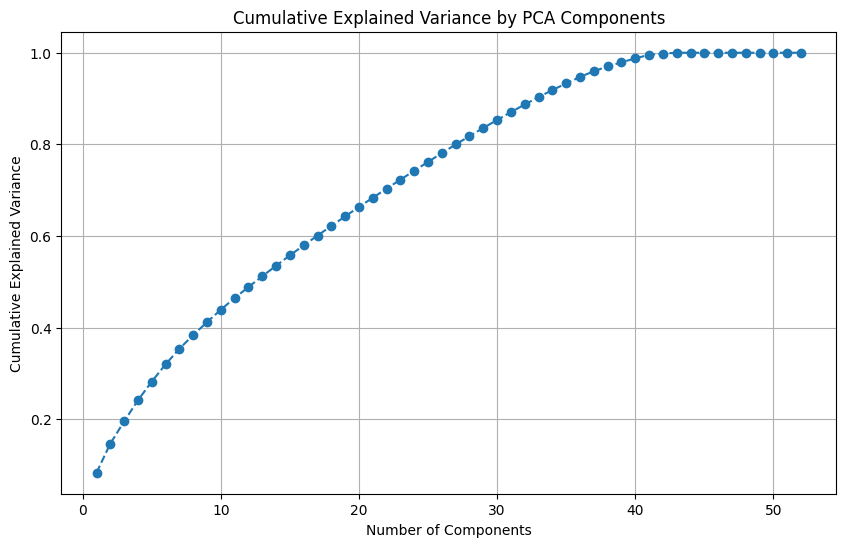

Number of components covering 95% variance: 37
F1 Score (PCA): 0.46237864077669905


2024/12/22 02:39:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run smiling-bat-574 at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/8/runs/ffcea7f115b94caea87367506c404140
🧪 View experiment at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/8


In [19]:
# step:9
# Experiment #5: Use PCA for dimensionality reduction on all the features.
# Create a scree plot to show which components will be selected for classification.
# Log results in MLFlow.

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# PCA for dimensionality reduction
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Scree plot for explained variance
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Selecting components covering 95% of variance
n_components = np.argmax(np.cumsum(explained_variance) >= 0.95) + 1
if n_components == 0:
    n_components = 1  # Ensure at least 1 component explains some variance
    print("Warning: No components explain 95% variance. Using 1 component.")
print(f"Number of components covering 95% variance: {n_components}")

# Reducing features to selected components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Logistic Regression with reduced features
pipeline = Pipeline([
    ('classifier', LogisticRegression())
])

pipeline.fit(X_train_pca, y_train)
y_pred = pipeline.predict(X_test_pca)

# Metrics
f1 = f1_score(y_test, y_pred)
print("F1 Score (PCA):", f1)
f1_scores["PCA"]=f1
mlflow.set_experiment(f"Bank Marketing Experiment - 5 (PCA)")
# Log results to MLFlow
with mlflow.start_run():
    mlflow.log_param("experiment", "PCA")
    mlflow.log_param("n_components", n_components)
    mlflow.log_metric("F1 Score", f1)
    mlflow.sklearn.log_model(pipeline, "model")

In [20]:
# step: 10
# Experiment #6: Design and execute a custom experiment. Log results in MLFlow.

X_train_exp6 = X_train.copy()
X_test_exp6 = X_test.copy()
X_train_exp6["interaction_balance_campaign"] = X_train_exp6["balance"] * X_train_exp6["campaign"]
X_test_exp6["interaction_balance_campaign"] = X_test_exp6["balance"] * X_test_exp6["campaign"]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['balance', 'duration', 'campaign', 'pdays', 'previous', 'interaction_balance_campaign']),
    ('cat', OneHotEncoder(), ['job', 'marital_status', 'education', 'loan_status', 'housing', 'loan', 'contact', 'month', 'poutcome'])
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train_exp6, y_train)
y_pred = pipeline.predict(X_test_exp6)

f1 = f1_score(y_test, y_pred)
print("F1 Score (Increased Features):", f1)
f1_scores["Increased Features"]=f1
mlflow.set_experiment(f"Bank Marketing Experiment - 6 (Increased Features)")
with mlflow.start_run():
    mlflow.log_param("experiment", "Increased Features")
    mlflow.log_metric("F1 Score", f1)
    mlflow.sklearn.log_model(pipeline, "model")

F1 Score (Increased Features): 0.4533169533169533


2024/12/22 02:39:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run suave-mole-849 at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/10/runs/6d07f97e3b864958bdab2ecdee1ea33b
🧪 View experiment at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/10


In [21]:
# step: 11
# Experiment #6: Design and execute a custom experiment. Log results in MLFlow.

X_train_exp7 = X_train.copy()
X_test_exp7 = X_test.copy()
X_train_reduced = X_train_exp7.drop(columns=["pdays", "previous"])
X_test_reduced = X_test_exp7.drop(columns=["pdays", "previous"])

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['balance', 'duration', 'campaign']),
    ('cat', OneHotEncoder(), ['job', 'marital_status', 'education', 'loan_status', 'housing', 'loan', 'contact', 'month', 'poutcome'])
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train_reduced, y_train)
y_pred = pipeline.predict(X_test_reduced)

f1 = f1_score(y_test, y_pred)
print("F1 Score (Reduced Features):", f1)
f1_scores["Reduced Features"]=f1
mlflow.set_experiment(f"Bank Marketing Experiment - 7 (Reduced Features)")
with mlflow.start_run():
    mlflow.log_param("experiment", "Reduced Features")
    mlflow.log_metric("F1 Score", f1)
    mlflow.sklearn.log_model(pipeline, "model")

F1 Score (Reduced Features): 0.44772447724477243


2024/12/22 02:40:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run amusing-vole-466 at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/11/runs/d7657d0f645c4631bbaa2715e6576970
🧪 View experiment at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/11


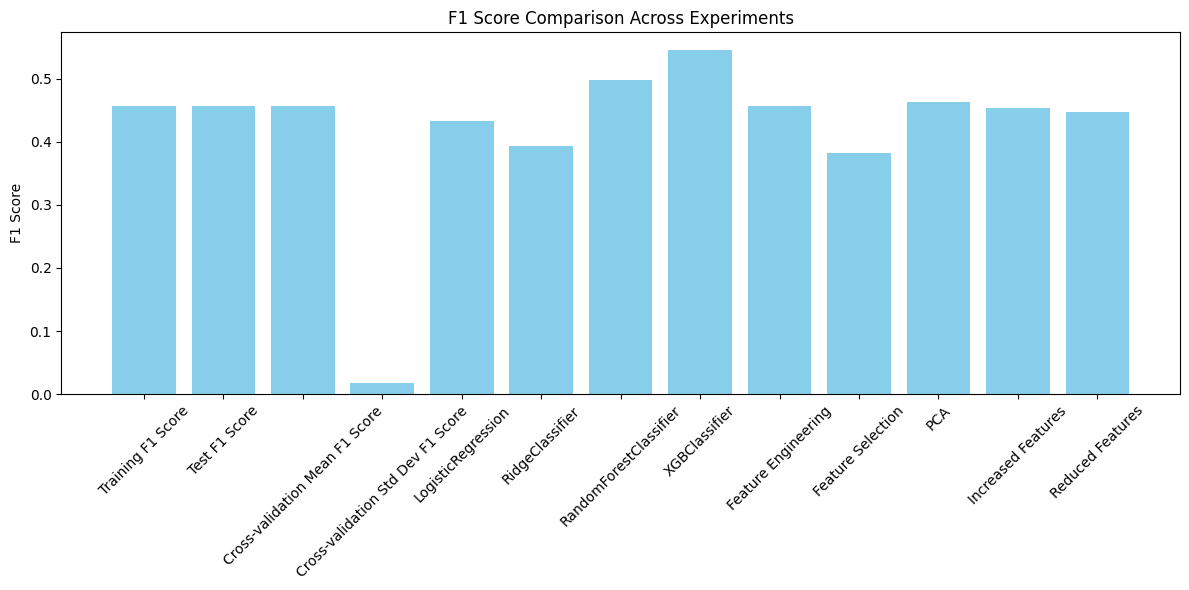

In [22]:
# step:12
# Create meaningful F1-score plots to compare experiments and determine the best model.
methods = list(f1_scores.keys())
scores = list(f1_scores.values())

# Plot
plt.figure(figsize=(12, 6))
plt.bar(methods, scores, color='skyblue')
plt.title('F1 Score Comparison Across Experiments')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
# Close database connection
conn.close()

In [24]:
import joblib
joblib.dump(forest, "final_model.pkl")


['final_model.pkl']

,client_id,age,balance,day,duration,campaign,pdays,previous
24001,24002,36,861,29,140,2,-1,0
43409,43410,24,4126,5,907,4,185,7
20669,20670,44,244,12,1735,4,-1,0
18810,18811,48,0,31,35,11,-1,0
23130,23131,38,257,26,57,10,-1,0


In [ ]:
X

,client_id,age,job,marital_status,education,loan_status,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,1,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,2,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,3,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,4,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,5,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,45207,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown
45207,45208,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown
45208,45209,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success
45209,45210,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown


['bank_marketing_pipeline.joblib']

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import f1_score
import joblib
import mlflow
import mlflow.sklearn

# Step 1: Setup the database
data_full = pd.read_csv('/content/bank-full.csv', sep=',')

conn = sqlite3.connect('bank_marketing.db')
cursor = conn.cursor()

cursor.execute('''CREATE TABLE IF NOT EXISTS clients (
    client_id INTEGER PRIMARY KEY AUTOINCREMENT,
    age INTEGER,
    job TEXT,
    marital_status TEXT,
    education TEXT,
    loan_status TEXT,
    balance INTEGER,
    housing TEXT,
    loan TEXT
)''')

cursor.execute('''CREATE TABLE IF NOT EXISTS campaigns (
    campaign_id INTEGER PRIMARY KEY AUTOINCREMENT,
    client_id INTEGER,
    contact TEXT,
    day INTEGER,
    month TEXT,
    duration INTEGER,
    campaign INTEGER,
    pdays INTEGER,
    previous INTEGER,
    poutcome TEXT,
    y TEXT,
    FOREIGN KEY(client_id) REFERENCES clients(client_id)
)''')

def normalize_and_insert_data(df):
    for _, row in df.iterrows():
        cursor.execute('''INSERT INTO clients (age, job, marital_status, education, loan_status, balance, housing, loan)
                          VALUES (?, ?, ?, ?, ?, ?, ?, ?)''',
                       (row['age'], row['job'], row['marital'], row['education'],
                        row['default'], row['balance'], row['housing'], row['loan']))
        client_id = cursor.lastrowid
        cursor.execute('''INSERT INTO campaigns (client_id, contact, day, month, duration, campaign, pdays, previous, poutcome, y)
                          VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)''',
                       (client_id, row['contact'], row['day'], row['month'], row['duration'],
                        row['campaign'], row['pdays'], row['previous'], row['poutcome'], row['y']))

normalize_and_insert_data(data_full)
conn.commit()

# Step 2: Fetch data from the database
query = '''
SELECT c.*, cp.contact, cp.day, cp.month, cp.duration, cp.campaign, cp.pdays, cp.previous, cp.poutcome, cp.y
FROM clients c
JOIN campaigns cp ON c.client_id = cp.client_id
'''
data_from_db = pd.read_sql_query(query, conn)

# Step 3: Train/Test Split
X = data_from_db.drop('y', axis=1)
print(X.columns)
y = data_from_db['y'].apply(lambda x: 1 if x == 'yes' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 4: Feature Selection
# Feature Selection with Variance Threshold
var_threshold = VarianceThreshold(threshold=0.01)
X_train_var = var_threshold.fit_transform(X_train.select_dtypes(include=np.number))
X_test_var = var_threshold.transform(X_test.select_dtypes(include=np.number))

# Step 5: Create and Train the Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale the numerical features
    ('classifier', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train_var, y_train)

# Step 6: Evaluate the Model
y_pred = pipeline.predict(X_test_var)
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Step 7: Save the Pipeline as a Joblib File
joblib_file_path = "bank_marketing_pipeline.joblib"
joblib.dump(pipeline, joblib_file_path)
print(f"Pipeline saved to {joblib_file_path}")

# Step 8: Log Results with MLflow
mlflow.set_experiment("Bank Marketing Pipeline")
with mlflow.start_run():
    mlflow.log_param("Model", "Logistic Regression")
    mlflow.log_metric("F1 Score", f1)
    mlflow.sklearn.log_model(pipeline, "model")

print("MLflow logging complete.")


F1 Score: 0.26990291262135924
Pipeline saved to bank_marketing_pipeline.joblib


2024/12/20 22:26:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run burly-snipe-469 at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/12/runs/060126e2b256465c872339062ca9bad9
🧪 View experiment at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/12
MLflow logging complete.


# New Section

In [ ]:
print(X.columns)

Index(['client_id', 'age', 'job', 'marital_status', 'education', 'loan_status',
       'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration',
       'campaign', 'pdays', 'previous', 'poutcome'],
      dtype='object')


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=pipeline.named_steps['classifier'].classes_)
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
conf_matrix_file_path = "confusion_matrix.png"
plt.savefig(conf_matrix_file_path)  # Save the plot
plt.close()

# Log Results with MLflow
mlflow.set_experiment("Bank Marketing Pipeline")
with mlflow.start_run():
    mlflow.log_param("Model", "Logistic Regression")
    mlflow.log_metric("F1 Score", f1)
    mlflow.sklearn.log_model(pipeline, "model")

    # Log the confusion matrix as an artifact
    mlflow.log_artifact(conf_matrix_file_path)

print("Confusion matrix logged to MLflow.")

2024/12/20 22:26:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run treasured-snake-340 at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/12/runs/d0dbd32d5ebc446a8b3f3fc41bbf8f9d
🧪 View experiment at: https://dagshub.com/kokkirala.vaishnavi15/Major-Project.mlflow/#/experiments/12
Confusion matrix logged to MLflow.


<Figure size 800x600 with 0 Axes>